In [26]:
using LightGraphs, PyPlot

In [116]:
# a function for BGSM_general (Section 2,3)

# y : a vector of data
# D : graph incidence matrix
# X : a design matrix
# w : a support vector
# nu : a prior precision for alpha
# v0, v1 : tuning parameters
# a, b : inverse gamma hyperparameters
# convtol : convergence tolerance
# orthotol : tolerance to check whether w is an eigenvector of X'X
# iter : a number of maximum allowed iteration

function BGSM_general(    y, D;                                 # a 
                          X = zeros(0,0), w = zeros(0),         # a design matrix and a support vector
                          nu = 0,                               # a prior precision for alpha
                          v0 = 1e-1, v1 = 1e4,                  # tuning parameters
                          a = 0, b = 1,                         # inverse gamma hyperparmeters
                          A = 1, B = 1,                         # beta bernoulli hyperparmeters
                          convtol = 1e-10, orthotol = 1e-10,    # tolerances
                          iter = 1000,                          # a number of maximum allowed iteration
                          verbose = true)                       # verbose option
    
    # n is the length of vector y
    n = length(y);
    m,p = size(D);
    if verbose == true
        println("A data \"y\" has input of length \"n\" = $n");
        println("A graph incidence matrix \"D\" has input of size (\"m\" = $m,\"p\" = $p)");
    end

    if size(X) == (0,0)
        if verbose == true
            println("A design matrix \"X\" has no input: use speye(n) as a default, \"n\" = $n");
        end
        X = speye(n);
    elseif size(X,1) != n
        error("Error: A data \"y\" has length \"n\" = $n thus a design matrix \"X\" must have $n rows.");
    end
    
    if length(w) == 0
        if verbose == true
            println("A support vector \"w\" has no input: use ones(p) as a default, \"p\" = $p");
        end
        w = ones(p);
    elseif length(w) != p
        error("Error: A graph incidence matrix \"D\" has \"p\" = $p columns thus a support vector \"w\" must have $p rows.");
    end
    
    if nu == 0
        # orthogonality check
        temp = X'*X*w;
        alpha = w'*X'*y / norm(w)^2;
        if norm(temp/norm(temp) - w/norm(w)) < orthotol && verbose == true
            println("\"w\" seems an eigenvector of \"X'*X\". We use a simpler algorithm.");
        end
    elseif nu == Inf
        alpha = 0;
    else
        Error("\"ν\" values other than 0 or ∞ are not being implemented yet.")
    end

    # initialization
    theta = (X'*X + 1e-4 * speye(p))\(X'*(y - alpha));
    delta = D * theta;
    if X == speye(n)
        sigmasq = sum((y - alpha).^2)/n;
    else
        sigmasq = 1;
    end
    eta = 1/2;
    q = ones(m)/2; q_old = copy(q);
    if verbose == true
        println("We initialize at \"α\" = mean(y), \"θ\" = y-α, \"σ^2\" = var(y) and \"η\" = 1/2");
    end

    # loop start
    for i = 1:iter
        
        # E-step : update q and tau
        q = 1./( 1 + (1-eta)/eta * sqrt(v0/v1) * exp.(delta.^2/2 * (1/v0 - 1/v1)/sigmasq) );
        tau = q/v0 + (1-q)/v1;
        
        # M-step : update theta, delta, sigma^2
        theta = (X'*X + D'*Diagonal(tau)*D) \ (X'*(y - alpha));
        theta = theta - (w'*theta) * w/norm(w)^2; # projection
        delta = D * theta;
        sigmasq = (sum((y - alpha - X*theta).^2) + sum((delta .* sqrt.(tau)).^2) + b)/(n+m+a+1);

        # convergence criterion
        err = norm(q - q_old)/length(q);
        
        # convergence check
        if err < convtol
            if verbose == true
                @printf "iteration: %d, error: %0.2e\n" i err;
                println("the algorithm converges at $i-th iteration");
            end
            break;
        end
        
        # printout
        if rem(i,5) == 0 && verbose == true
            @printf "iteration: %d, error: %0.2e\n" i err;
        end
        
        # update eta
        eta = (sum(q) + A - 1)/(m + A + B - 2);
        
        # save for convergence check
        q_old = copy(q);
    end
    return Dict([
                 (:alpha,alpha), (:theta,theta), (:delta, delta), (:q, q),
                 (:sigmasq,sigmasq), (:eta,eta), 
                 (:y, y), (:D, D), (:X,X), (:w, w), (:nu,nu),
                 (:n, n), (:p, p), (:m, m),
                 (:v0, v0), (:v1, v1)
               ])
end

BGSM_general (generic function with 1 method)

In [232]:
function model_selection(out)
    # thresholding step
    ind = find(out[:q] .>= 0.5);
    
    # get original graph
    A_orig = out[:D]'*out[:D]; A_orig = (abs.(A_orig) - A_orig)/2;
    
    # get a thresholded graph
    D = out[:D][ind,:]; L = D'*D;
    g = Graph((abs.(L) - L)/2);
    
    # edge contraction / node merger
    c = connected_components(g);
    s = length(c);
    
    # get reduced X, w
    if out[:X] == speye(out[:n]) || out[:w] == ones(out[:n])
        X = zeros(out[:n],s);
        for i = 1:s
            X[c[i],i] = 1;
        end
        w = ones(s);
    elseif out[:w] == [1;zeros(out[:p]-1)]
        S = collect(Iterators.flatten(c[2:end]));
        X = zeros(out[:n],s); X[:,2:end] = out[:X][:,S];
        w = sparse(zeros(s)); w[1] = 1;
    else
        error("For this case of \"x\" and \"w\", model selection is not supported yet.")
    end
    
    # get reduced P
    P = speye(s) - w*w'/norm(w)^2;
    
    # get a reduced model graph-algebraic objects
    A = zeros(s,s);
    for i = 1:s
        for j = i+1:s
            A[i,j] = sum(A_orig[c[i],c[j]]);
        end
    end
    A = (A .> 0); A = A + A';
    L = Diagonal(sum(A,2)[:]) - A; L = L/out[:v1];
    H = X'*X + P*L*P + out[:nu]*w*w'/norm(w)^2;
    
    # t_reduced : a vector of length s, which equals reduced alpha w + reduced theta
    t_reduced = zeros(s);
    if out[:nu] == Inf # just to avoid numerical issue - convention does not work here
        H = H[2:end,2:end]; L = L[2:end,2:end];
        eig_L = sort(eig(L)[1]);
        eig_H = sort(eig(H)[1]);
        t_reduced[2:end] = H\(X[:,2:end]'*y);
    else
        eig_L = sort(eig(L)[1])[2:end];
        eig_H = sort(eig(H)[1])[2:end];
        t_reduced = H\(X'*y);    
    end
    
    # t_full : a vector of length p, which equals full alpha w + full theta
    t_full = zeros(out[:p]);
    for i = 1:s
        t_full[c[i]] = t_reduced[i];
    end
    
    # Xt : X * t_reduced
    Xt = X*t_reduced;

    
    # model selection scores
    # first_term = -1/2 * log det_w(L), negative log-sum of nonzero eigenvalues of L
    first_term = -sum(log.(eig_L))/2;
    # second_term = 1/2 * log det_w(H), log-sum of nonzero eigenvalues of H
    second_term = sum(log.(eig_H))/2;
    # third_term = n/2 * log l2 loss 
    third_term = log(sum((y-X*t_reduced).^2)) * n/2;
    
    return Dict([(:t_reduced, t_reduced), (:Xt, Xt), (:t_full, t_full),
                 (:each, (first_term, second_term, third_term)),
                 (:X, X), (:H, H), (:A, A), (:w, w), (:s, s), (:c, c),
                 (:score, first_term + second_term + third_term)
                ])
end

model_selection (generic function with 2 methods)

In [243]:
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);
Theta = 5 * ceil.(2.8 * Th - 0.2);
theta = Theta[:]; n = length(theta);
sigma = 1.0;
srand(1);
y = theta + sigma * randn(n); Y = reshape(y,21,21);
g = Grid([21;21]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
out = BGSM_general(y,D, v0 = 1e-3 * 10, v1 = 1e4, b = sum(size(D)), verbose = true)

A data "y" has input of length "n" = 441
A graph incidence matrix "D" has input of size ("m" = 840,"p" = 441)
A design matrix "X" has no input: use speye(n) as a default, "n" = 441
A support vector "w" has no input: use ones(p) as a default, "p" = 441
"w" seems an eigenvector of "X'*X". We use a simpler algorithm.
We initialize at "α" = mean(y), "θ" = y-α, "σ^2" = var(y) and "η" = 1/2
iteration: 5, error: 2.06e-03
iteration: 8, error: 9.48e-13
the algorithm converges at 8-th iteration


Dict{Symbol,Any} with 16 entries:
  :alpha   => 5.32921
  :p       => 441
  :n       => 441
  :D       => [1 -1 … 0 0; 1 0 … 0 0; … ; 0 0 … -1 0; 0 0 … 1 -1]
  :delta   => [0.000667633, 0.00113498, 0.00390052, -0.000572224, 0.00120819, -…
  :w       => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1…
  :eta     => 0.748557
  :nu      => 0
  :X       => …
  :v1      => 10000.0
  :q       => [0.999664, 0.999664, 0.999664, 0.999664, 0.999664, 0.999664, 0.0,…
  :m       => 840
  :v0      => 0.01
  :y       => [-4.70271, -4.6176, -5.59763, -5.01045, -0.839027, 0.311111, 2.29…
  :theta   => [-10.2121, -10.2128, -10.2167, -10.2179, -5.32839, -5.32522, -5.3…
  :sigmasq => 1.33319

In [244]:
# model selection result
out_ms = model_selection(out)

Dict{Symbol,Any} with 11 entries:
  :c         => Array{Int64,1}[[1, 2, 3, 4, 22, 23, 24, 43, 44, 64], [5, 6, 7, …
  :score     => 1397.84
  :w         => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  :t_reduced => [-4.88839, 0.00366643, -5.75669, 5.04009, 9.97776, 3.29098, 14.…
  :each      => (43.2048, 13.734, 1340.9)
  :X         => [1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0…
  :A         => [0 1 … 0 0; 1 0 … 1 1; … ; 0 1 … 0 0; 0 1 … 0 0]
  :s         => 11
  :Xt        => [-4.88839, -4.88839, -4.88839, -4.88839, 0.00366643, 0.00366643…
  :H         => [10.0001 -0.0001 … 2.25678e-21 2.20702e-21; -0.0001 109.001 … -…
  :t_full    => [-4.88839, -4.88839, -4.88839, -4.88839, 0.00366643, 0.00366643…

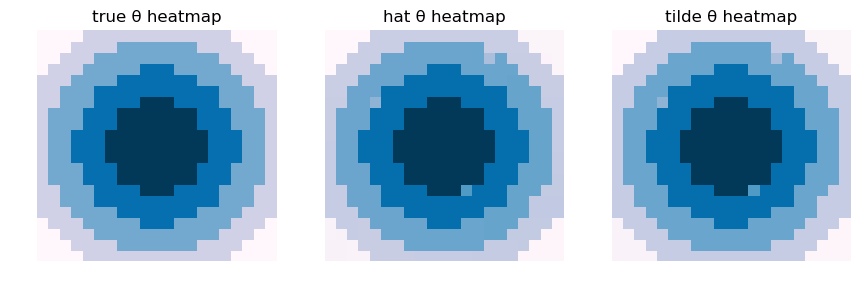

misclassificiation rate: 0.0131


In [251]:
fig = figure(figsize = (10.5,3));
subplot(131); pcolormesh(Theta, cmap = "PuBu"); axis("off"); title("true θ heatmap");
subplot(132); pcolormesh(reshape(out[:alpha] + out[:theta],21,21), cmap = "PuBu"); axis("off"); title("hat θ heatmap");
subplot(133); pcolormesh(reshape(out_ms[:t_full],21,21), cmap = "PuBu"); axis("off"); title("tilde θ heatmap");
hat_gamma = (out[:q] .> 0.5); gamma = (D*theta .== 0);
missed = sum(gamma .* (1-hat_gamma)) + sum((1-gamma) .* hat_gamma)
println("misclassificiation rate: ", round(missed/out[:m],4));

In [253]:
srand(1);
n = 100; p = 200;
X = randn(n,p); X1 = [zeros(n) X];
w = [1;zeros(p)];
t = [zeros(Int(4*p/5));5.0*ones(Int(p/5))]
y = X*t + randn(n);
g = Graph(p+1);
for i = 1:p
    add_edge!(g,(1,i+1))
end
A = adjacency_matrix(g);
D = full(incidence_matrix(g, oriented = true))';
out = BGSM_general(y, D, v0 = 1e-1*0.8, X = X1, w = w, A = size(D,2), b = sum(size(D)), nu = Inf)

A data "y" has input of length "n" = 100
A graph incidence matrix "D" has input of size ("m" = 200,"p" = 201)
We initialize at "α" = mean(y), "θ" = y-α, "σ^2" = var(y) and "η" = 1/2
iteration: 5, error: 6.37e-03
iteration: 10, error: 5.01e-04
iteration: 15, error: 9.97e-05
iteration: 20, error: 2.43e-03
iteration: 25, error: 8.66e-04
iteration: 30, error: 2.97e-04
iteration: 35, error: 7.98e-04
iteration: 38, error: 6.64e-13
the algorithm converges at 38-th iteration


Dict{Symbol,Any} with 16 entries:
  :alpha   => 0
  :p       => 201
  :n       => 100
  :D       => [-1 1 … 0 0; -1 0 … 0 0; … ; -1 0 … 1 0; -1 0 … 0 1]
  :delta   => [-0.0191805, -0.0120603, 0.0715204, 0.0360596, -0.0695142, 0.0137…
  :w       => [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0…
  :eta     => 0.899873
  :nu      => Inf
  :X       => [0.0 0.297288 … 1.55131 0.410975; 0.0 0.382396 … -0.886303 1.1673…
  :v1      => 10000.0
  :q       => [0.999685, 0.999685, 0.999678, 0.999683, 0.999678, 0.999685, 0.99…
  :m       => 200
  :v0      => 0.08
  :y       => [35.737, -55.1175, 21.0849, -39.1381, 19.8212, -5.80741, 22.7392,…
  :theta   => [0.0, -0.0191805, -0.0120603, 0.0715204, 0.0360596, -0.0695142, 0…
  :sigmasq => 1.34915

In [254]:
# model selection result
out_ms = model_selection(out)

Dict{Symbol,Any} with 11 entries:
  :c         => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  152, 153, 154…
  :score     => 458.127
  :w         =>   [1 ]  =  1.0
  :t_reduced => [0.0, 4.84773, 4.95546, 5.06888, 4.92423, 4.81965, 5.14335, 5.0…
  :each      => (184.207, 87.3752, 186.545)
  :X         => [0.0 -0.442912 … 1.55131 0.410975; 0.0 -0.863675 … -0.886303 1.…
  :A         => [0 1 … 1 1; 1 0 … 0 0; … ; 1 0 … 0 0; 1 0 … 0 0]
  :s         => 41
  :Xt        => [35.9289, -55.4433, 21.0323, -39.5484, 20.0262, -5.85848, 24.69…
  :H         => [108.813 2.31559 … 15.3492 -27.9349; 2.31559 110.611 … 4.92077 …
  :t_full    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  4.88506, …

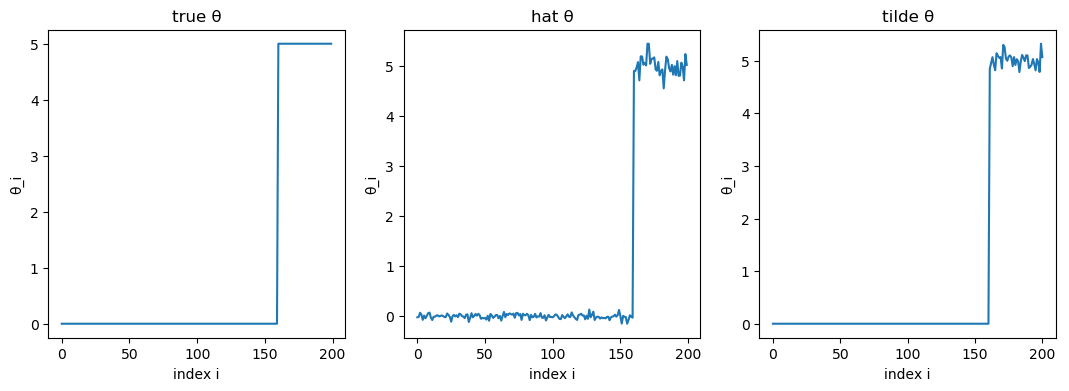

misclassificiation rate: 0.0


In [258]:
fig = figure(figsize = (13,4));
subplot(131); plot(t); xlabel("index i"); ylabel("θ_i"); title("true θ");
subplot(132); plot(out[:delta]); xlabel("index i"); ylabel("θ_i"); title("hat θ");
subplot(133); plot(out_ms[:t_full]); xlabel("index i"); ylabel("θ_i"); title("tilde θ");
hat_gamma = (out[:q] .> 0.5); gamma = (t .== 0);
missed = sum(gamma .* (1-hat_gamma)) + sum((1-gamma) .* hat_gamma);
println("misclassificiation rate: ", round(missed/out[:m],4));